# Exploratory Data Analysis of Trashnet Data-set

In [25]:
import os
import random
import time
import matplotlib.pyplot as plt
import cv2

# sklearn
from sklearn.model_selection import train_test_split

# numpy
import numpy as np

# Tensorflow
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.python.keras import backend as K
from tensorflow.python.keras.utils.layer_utils import count_params
from keras.callbacks import EarlyStopping

# Tensorflow Hub
import tensorflow_hub as hub

AUTOTUNE = tf.data.experimental.AUTOTUNE

In [2]:
data_dir = os.path.join("../data", "dataset-resized")
label_names = os.listdir( data_dir)
num_classes = len(label_names)

# Create label index for easy lookup
label2index = dict((name, index) for index, name in enumerate(label_names))
index2label = dict((index, name) for index, name in enumerate(label_names))

print("Number of classes:", num_classes)
print("Labels:", label_names)

Number of classes: 6
Labels: ['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']


In [3]:
# Generate a list of labels and path to text
data_x = []
data_y = []
sample_images = {}

for label in label_names:
  text_files = os.listdir(os.path.join(data_dir,label))
  data_x.extend([os.path.join(data_dir,label,f) for f in text_files])
  data_y.extend([label for f in text_files])
  sample_images[label] = random.sample(text_files, 4) 

# Preview
print("data_x count:",len(data_x))
print("data_y count:",len(data_y))
print(data_x[:5])
print(data_y[:5])

data_x count: 2527
data_y count: 2527
['../data\\dataset-resized\\cardboard\\cardboard1.jpg', '../data\\dataset-resized\\cardboard\\cardboard10.jpg', '../data\\dataset-resized\\cardboard\\cardboard100.jpg', '../data\\dataset-resized\\cardboard\\cardboard101.jpg', '../data\\dataset-resized\\cardboard\\cardboard102.jpg']
['cardboard', 'cardboard', 'cardboard', 'cardboard', 'cardboard']


## Display Sample of Images Per Class

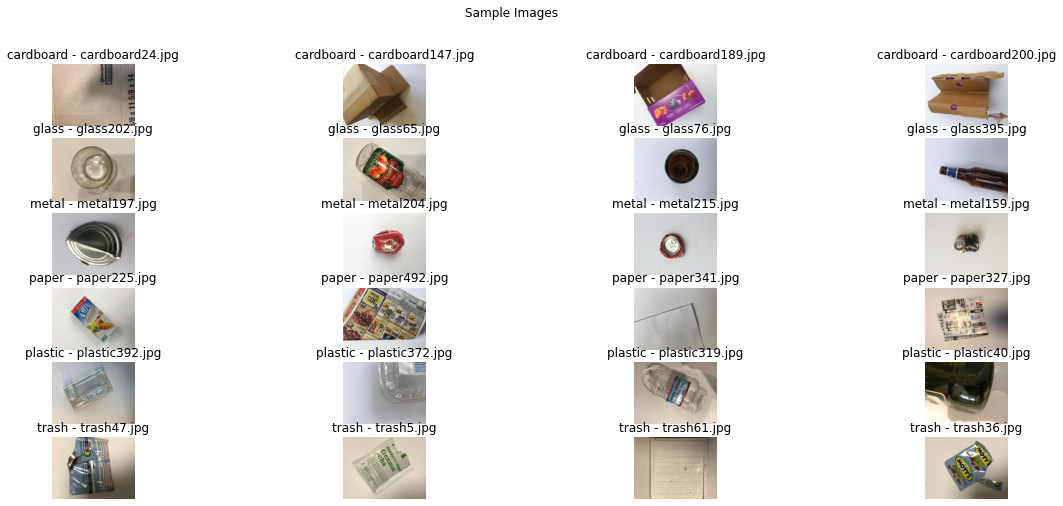

In [4]:
# Display a sample of each class type

fig = plt.figure(figsize=(20,8))

img_pos = 1
for label in sample_images:
    for file in sample_images[label]:
        axs = fig.add_subplot(num_classes,4,img_pos)
        axs.set_title(f"{label} - {file}")
        image = cv2.imread(os.path.join(data_dir,label,file))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        plt.imshow(image)
        plt.axis('off')
        img_pos += 1

plt.suptitle("Sample Images")
plt.show()

## Build Data Pipeline

In [5]:
validation_percent = 0.1

# Split data into train / validate
train_x, validate_x, train_y, validate_y = train_test_split(data_x, data_y, test_size=validation_percent)

print("train_x count:",len(train_x))
print("validate_x count:",len(validate_x))

# Convert all y labels to numbers
train_processed_y = [label2index[label] for label in train_y]
validate_processed_y = [label2index[label] for label in validate_y]

train_x count: 2274
validate_x count: 253


In [7]:
# Pipeline Creation

image_width = 256
image_height = 192

num_channels = 3
batch_size = 32
train_shuffle_buffer_size = len(train_x)
validation_shuffle_buffer_size = len(validate_x)

# Create TF Dataset
train_data = tf.data.Dataset.from_tensor_slices((train_x, train_processed_y))
validation_data = tf.data.Dataset.from_tensor_slices((validate_x, validate_processed_y))

# Load Image
def load_image(path, label):
  image = tf.io.read_file(path)
  image = tf.image.decode_jpeg(image, channels=num_channels)
  image = tf.image.resize(image, [image_height,image_width])
  return image, label

# Normalize pixels
def normalize(image, label):
  image = image/255
  return image, label

# Augment data
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
  layers.experimental.preprocessing.RandomZoom(0.2, 0.2),
])

def build_pipeline( tf_data, augment=False ):
  """Build a TF Dataset Pipeline."""
  tf_data = tf_data.shuffle(buffer_size=train_shuffle_buffer_size, seed=6767)
  tf_data = tf_data.map(load_image, num_parallel_calls=AUTOTUNE)
  tf_data = tf_data.map(normalize, num_parallel_calls=AUTOTUNE)
  
  if (augment):
    tf_data = tf_data.map(lambda x, y: (data_augmentation(x, training=True), y), num_parallel_calls=AUTOTUNE)
  
  tf_data = tf_data.batch(batch_size)
  tf_data = tf_data.prefetch(AUTOTUNE)
  return tf_data

# Build the training and validation data-sets
train_data = build_pipeline (train_data, augment=True)
validation_data = build_pipeline(validation_data, augment=False)

print("train_data",train_data)
print("validation_data",validation_data)

train_data <PrefetchDataset shapes: ((None, 224, 224, 3), (None,)), types: (tf.float32, tf.int32)>
validation_data <PrefetchDataset shapes: ((None, 224, 224, 3), (None,)), types: (tf.float32, tf.int32)>


## Build Classification Model

In [15]:
def build_transfer_model(image_height, image_width, num_channels, num_classes):
  """Build a transfer model based on mobile-net pre-trained architecture."""
  input_shape = [image_height, image_width, num_channels] # height, width, channels
  handle = "https://tfhub.dev/google/imagenet/inception_resnet_v2/classification/5"

  # Regularize using L1
  kernel_weight = 0.02
  bias_weight = 0.02

  model = Sequential([
        keras.layers.InputLayer(input_shape=input_shape),hub.KerasLayer(handle, trainable=False),
        keras.layers.Dense(units=124, activation='relu',kernel_regularizer=keras.regularizers.l1(kernel_weight), bias_regularizer=keras.regularizers.l1(bias_weight)),
        keras.layers.Dense(units=64, activation='relu',kernel_regularizer=keras.regularizers.l1(kernel_weight), bias_regularizer=keras.regularizers.l1(bias_weight)),
        keras.layers.Dense(units=num_classes, activation=None, kernel_regularizer=keras.regularizers.l1(kernel_weight), bias_regularizer=keras.regularizers.l1(bias_weight)),
  ],name='transfer_model')

  return model

In [18]:
# Model Training Parameters
learning_rate = 0.01
epochs = 25

# Free up memory
K.clear_session()

# Model parameters
optimizer = keras.optimizers.SGD(learning_rate=learning_rate)
loss = keras.losses.SparseCategoricalCrossentropy(from_logits=True)
es = EarlyStopping(monitor='val_accuracy', verbose=1, patience=3)
lr = keras.callbacks.LearningRateScheduler(lambda epoch: learning_rate/(1+.5*epoch) )

# Execute different model approaches and save experiment results:
model = build_transfer_model(image_height, image_width, num_channels, num_classes)

print(model.summary())
model.compile(loss=loss, optimizer=optimizer, metrics=["accuracy", "sparse_categorical_accuracy"])

Model: "transfer_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 1001)              55875273  
_________________________________________________________________
dense (Dense)                (None, 124)               124248    
_________________________________________________________________
dense_1 (Dense)              (None, 64)                8000      
_________________________________________________________________
dense_2 (Dense)              (None, 6)                 390       
Total params: 56,007,911
Trainable params: 132,638
Non-trainable params: 55,875,273
_________________________________________________________________
None


In [19]:
# Train model
start_time = time.time()
training_results = model.fit(
        train_data,
        validation_data=validation_data,
        epochs=epochs,
        callbacks=[es, lr],
        verbose=1)
execution_time = (time.time() - start_time)/60.0
print("Training execution time (mins)",execution_time)

# Get model training history
training_history = training_results.history

Epoch 1/25
72/72 [==============================] - 45s 459ms/step - loss: 89.6892 - accuracy: 0.6504 - sparse_categorical_accuracy: 0.6504 - val_loss: 72.5306 - val_accuracy: 0.6877 - val_sparse_categorical_accuracy: 0.6877
Epoch 2/25
72/72 [==============================] - 30s 414ms/step - loss: 62.7998 - accuracy: 0.7753 - sparse_categorical_accuracy: 0.7753 - val_loss: 53.3805 - val_accuracy: 0.7787 - val_sparse_categorical_accuracy: 0.7787
Epoch 3/25
72/72 [==============================] - 30s 411ms/step - loss: 47.2638 - accuracy: 0.7929 - sparse_categorical_accuracy: 0.7929 - val_loss: 41.3636 - val_accuracy: 0.7628 - val_sparse_categorical_accuracy: 0.7628
Epoch 4/25
72/72 [==============================] - 28s 394ms/step - loss: 37.0690 - accuracy: 0.7986 - sparse_categorical_accuracy: 0.7986 - val_loss: 32.9854 - val_accuracy: 0.7628 - val_sparse_categorical_accuracy: 0.7628
Epoch 5/25
72/72 [==============================] - 28s 390ms/step - loss: 29.8727 - accuracy: 0.800

In [23]:
def evaluate_model(model,test_data, model_train_history):
  
  # Get the number of epochs the training was run for
  num_epochs = len(model_train_history["loss"])

  # Plot training results
  fig = plt.figure(figsize=(15,5))
  axs = fig.add_subplot(1,2,1)
  axs.set_title('Loss')
  # Plot all metrics
  for metric in ["loss","val_loss"]:
      axs.plot(np.arange(0, num_epochs), model_train_history[metric], label=metric)
  axs.legend()
  
  axs = fig.add_subplot(1,2,2)
  axs.set_title('Accuracy')
  # Plot all metrics
  for metric in ["accuracy","val_accuracy"]:
      axs.plot(np.arange(0, num_epochs), model_train_history[metric], label=metric)
  axs.legend()

  plt.show()
  
  # Evaluate on test data
  evaluation_results = model.evaluate(test_data)
  print(evaluation_results)

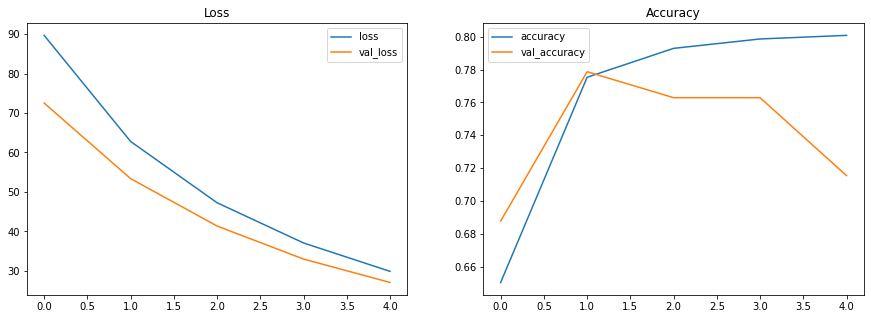

8/8 [==============================] - 3s 307ms/step - loss: 27.0581 - accuracy: 0.7154 - sparse_categorical_accuracy: 0.7154
[27.058074951171875, 0.7154150009155273, 0.7154150009155273]


In [26]:
evaluate_model( model, validation_data, training_history )